In [1]:
from collections import defaultdict 
import statistics
import os
import sys
import csv
import math
import random
import time
import networkx as nx
from matplotlib.pyplot import figure
from networkx.algorithms.flow import edmonds_karp
from pathlib import Path, PureWindowsPath
import FordFulkerson as ff
import EdmondsKarp as EK
from multiprocessing import Pool
from collections import Counter
from IPython.display import Image, display
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
total_time = time.time()

### createDirs(fold) 
creates lists of strings that contain the path to each graph file.

In [3]:
def createDirs(fold):
    path = "DATASET F1/fold_" +str(fold)
    mal_path = path+ "/20%_test"
    train_path = path+ "/80%_train"
    benign_path = "DATASET F1/specimen_benign/20%_test"
    
    w_mal_path = PureWindowsPath(mal_path)
    w_train_path= PureWindowsPath(train_path)
    w_benign_path = PureWindowsPath(benign_path)
    print( mal_path+"\n"+ train_path+"\n"+ benign_path)
    print( w_mal_path, w_train_path, w_benign_path)

    filename = "default_G_tone_map"
    mapFilename = "default_unique_mapping"
    
    rootDir = [os.path.join(root, name)
             for root, dirs, files in os.walk(w_mal_path)
             for name in files
             if name.endswith(filename+".csv")]
    rootDir.sort()

    benignDir = [os.path.join(root, name)
                 for root, dirs, files in os.walk(w_benign_path)
                 for name in files
                 if name.endswith(filename+".csv")]
    benignDir.sort()

    # for i in range(len(paths)):
    trainDir = [os.path.join(root, name)
                 for root, dirs, files in os.walk(w_train_path)
                 for name in files
                 if name.endswith(filename+".csv")]
    trainDir.sort()
    #     trainDirs[i] = trainDir
    return [rootDir,benignDir,trainDir]

### createGraphs(dirs,npmode)
imports the csv files and creates the nx.Graph() objects. Npmode returns numpy matrices of the graphs

In [4]:
def createGraphs(dirs,npmode):
    rootDir = dirs[0]
    benignDir = dirs[1]
    trainDir = dirs[2]
    mal_gs = []
    mal_np_gs = []
    ben_gs = []
    train_gs = []
    train_np_gs = []
    ben_np_gs = []
    csm_vals = {}
    
    for i in range(len(rootDir)):
        A = np.array(getArray(rootDir[i]))
        G = nx.from_numpy_matrix(A)
        x,y = A.shape
        mal_gs.append(G)
        mal_np_gs.append(np.reshape(A,x*y))
        
    for i in range(len(trainDir)):
        A = np.array(getArray(trainDir[i]))
        G = nx.from_numpy_matrix(A)        
        x,y = A.shape
        train_gs.append(G)
        train_np_gs.append(np.reshape(A,x*y))
        
    for i in range(len(benignDir)):
        A = np.array(getArray(benignDir[i]))
        x,y = A.shape
        G = nx.from_numpy_matrix(A)
        ben_gs.append(G)
        ben_np_gs.append(np.reshape(A,x*y))
        
    if npmode: 
        return [mal_np_gs, ben_np_gs, train_np_gs]
    else: 
        return [mal_gs, ben_gs, train_gs]

### getArray(path)
parses the csv file and returns a list with the contents of it.

In [5]:
def getArray (path):
    results = []
    with open(path) as csvfile:
        reader = csv.reader(csvfile,csv.QUOTE_NONNUMERIC) # change contents to floats
        for row in reader: # each row is a list
            nums = []
            for i in row: 
                if i :
                    nums.append(int(i))
            results.append(nums)
    return results

### similarityMetric(sr)
calculates and returns the classification values.

In [6]:
def similarityMetric(sr):
    counterA = 0
    counterB = 0
    counterC = 0
    for i in sr :
        A,B = i[0].split(',')[0], i[0].split(',')[1]
        C,D = i[2].split(',')[0], i[2].split(',')[1]
        if A==C and B==D:
            counterA +=1
        if A==C or B==D:
            counterB +=1
        if A==C or A==D or B == C or B == D:
            counterC += 1
#     print("cA = %d (%f) cB= %d (%f) cC =%d (%f)"%(counterA, counterA/len(sr), counterB, counterB/len(sr), counterC, counterC/len(sr)))
    return [counterA/len(sr),counterB/len(sr),counterC/len(sr)]

In [7]:
def saveFigures(mal_th, ben_th, start, iteration):
    lists = [mal_th,ben_th]
    diffs = []
    v = 0
    for i in range(len(mal_th)):
        v = max(v,abs(mal_th[i]-ben_th[i]))
        diffs.append(abs(mal_th[i]-ben_th[i]))
    print(v)
    d = max(diffs)
    print(d, mal_th[diffs.index(d)])

    for i in lists:
        plt.plot(i,marker= 11)
    plt.title("max dif at %f"%(diffs[diffs.index(d)]))
    plt.legend(["True positives","False positives"])
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0,step, 1))
    plt.ylabel("")
    plt.draw()
    try:
        os.mkdir(str(iteration))
    except OSError:
#         print ("Creation of the directory %s failed" % str(iteration))
        pass
    else:
        print ("Successfully created the directory %s" % str(iteration))
    plt.savefig(str(iteration)+"/"+str(start)+".png")
    plt.clf()



In [8]:
def detection(ben, mal, itr, step, metric = 'Csm' ):
    dif = ben[0]-ben[-1]
    thresh = [ben[-1]+i*dif/step for i in range(step)]
    m = np.array(sum(i > thresh for i in mal)/len(mal))
    p = np.array(sum(i > thresh for i in ben)/len(ben))
    for i in [m,p]:
        plt.plot(i)
    plt.yticks(np.arange(0,1.05,0.05))
    plt.xticks(np.arange(0,len(thresh),1))
    plt.draw()
    plt.title('detection at '+str(itr)+ ' iteration')
    plt.savefig(metric+"--"+ str(itr)+'--flow.png')
    plt.clf()
    return [m, p]


In [9]:
def sortTests(test):
    sortedTests =[]
    for i in range(len(test)):
        srTest = sorted(test[i], key = lambda kv:kv[1],reverse = True)
        sortedTests.append(srTest)
        
    return sortedTests

In [10]:
def detectSteps(testA, testB,step, metric = "Csm"):
    detect = []
    for i in range(len(testA)):
        detect.append(detection(testA[i], testB[i], i, step, metric=metric))
    return detect

In [11]:
def simAverages(malTest, benTest, metric):
    similarities = [similarityMetric(malTest[i]) for i in range(len(malTest))]
    for i in similarities :
        print(i)
    counts = [[i[j] for i in similarities] for j in range(len(i))]
    avg = [statistics.mean(i) for i in counts]
    print("---------------")
    print(metric)
    print("---------------")
    for j in avg : print(j)

In [12]:
itDirs = [createDirs(i)for i in range(1,6)]
maps = [createGraphs(itDirs[i], True)for i in range(len(itDirs))]

DATASET F1/fold_1/20%_test
DATASET F1/fold_1/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_1\20%_test DATASET F1\fold_1\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_2/20%_test
DATASET F1/fold_2/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_2\20%_test DATASET F1\fold_2\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_3/20%_test
DATASET F1/fold_3/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_3\20%_test DATASET F1\fold_3\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_4/20%_test
DATASET F1/fold_4/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_4\20%_test DATASET F1\fold_4\80%_train DATASET F1\specimen_benign\20%_test
DATASET F1/fold_5/20%_test
DATASET F1/fold_5/80%_train
DATASET F1/specimen_benign/20%_test
DATASET F1\fold_5\20%_test DATASET F1\fold_5\80%_train DATASET F1\specimen_benign\20%_test


In [13]:
def trial(metric, mode = True):
    t = time.time()
    
    malwareTests = [calculateDifference(maps[i][0],maps[i][2], 
                                        itDirs[i], False, metric = metric) for i in range(1)]
    print("malware took %f seconds"%(time.time()-t))
    benignTests = [calculateDifference(maps[i][1],maps[i][2], 
                                           itDirs[i], True, metric = metric) for i in range(1)]
    return [malwareTests,benignTests]

In [14]:
def getSortTests(benignTests,malwareTests):
    sortBenignTests= sortTests(benignTests)
    sortMalwareTests =  sortTests(malwareTests)
    return [sortBenignTests, sortMalwareTests]

In [15]:
def getTestValues(sortMalwareTests,sortBenignTests):
    malwares =  [[sortMalwareTests[j][i][1] for i in range(len(sortMalwareTests[j]))] 
             for j in range(len(sortMalwareTests))]
    benigns =  [[sortBenignTests[j][i][1] for i in range(len(sortBenignTests[j]))] 
             for j in range(len(sortBenignTests))]
    return [malwares, benigns]

In [16]:
def calculateDifference(listA, listB, dirs,isBenign, metric = "csm"):
    time_to = time.time()
    ret_val = []
    rootDir = dirs[0]
    benDir = dirs[1]
    trainDir = dirs[2]
    stats= []
    if metric == "csm" :
        for i in range(len(listA)):
            val = []
            e_val = []
            for j in range(len(listB)):
                val.append(1-distance.cosine(listA[i], listB[j]))
            
            val_ar = [k for k, j in enumerate(val) if j == max(val)]
            stats.append(len(val_ar))
            best = val.index(max(val))
            for v in val_ar:
                if isBenign:
                    if benDir[i].split('\\')[-3] == trainDir[v].split('\\')[-3]:
                        best = v
                else :
                    if rootDir[i].split('\\')[-3] == trainDir[v].split('\\')[-3]:
                        best = v
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],val[best],trainDir[best].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],val[best],trainDir[best].split('\\')[-3]])
        plt.hist(stats, bins= 10)
        print(str(time.time()-time_to)+ "CSM TIME")
        return ret_val
    elif metric == "euc":
        for i in range(len(listA)):
            e_val = []
            for j in range(len(listB)):
                e_val.append(1000.0/(1000.0+distance.euclidean(listA[i], listB[j])))
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
        print(str(time.time()-time_to)+ "EUC TIME")
        return ret_val
    elif metric == "bray":
        for i in range(len(listA)):
            e_val = []
            for j in range(len(listB)):
                e_val.append(1-distance.braycurtis(listA[i], listB[j]))
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
        print(str(time.time()-time_to)+ "Bray TIME")
        return ret_val
    elif metric == "sqeuc":
        for i in range(len(listA)):
            e_val = []
            for j in range(len(listB)):
                e_val.append(1000.0/(1000.0+distance.sqeuclidean(listA[i], listB[j])))
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
        print(str(time.time()-time_to)+ "SQEUC TIME")
        return ret_val
    elif metric == "cor":
        for i in range(len(listA)):
            e_val = []
            for j in range(len(listB)):
                e_val.append(1000.0/(1000.0+distance.correlation(listA[i], listB[j])))
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
        print(str(time.time()-time_to)+ "COR TIME")
        return ret_val
    elif metric == "prod":
        for i in range(len(listA)):
            e_val = []
            for j in range(len(listB)):
                a = 1-distance.braycurtis(listA[i], listB[j])
                b = 10000.0/(10000.0+distance.sqeuclidean(listA[i],listB[j]))
                e_val.append(a*b)
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
        print(str(time.time()-time_to)+ "PROD TIME")
        return ret_val
    elif metric == "mink":
        for i in range(len(listA)):
            e_val = []
            for j in range(len(listB)):
                a= 1000.0/(1000.0+distance.minkowski(listA[i], listB[j],1))
                b= 1000.0/(1000.0+distance.cosine(listA[i], listB[j]))
                e_val.append(a*b)
            if isBenign:
                ret_val.append([benDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
            else :
                ret_val.append([rootDir[i].split('\\')[-3],max(e_val),trainDir[e_val.index(max(e_val))].split('\\')[-3]])
        
        print(str(time.time()-time_to)+ "Mink TIME")
        return ret_val

83.10482907295227CSM TIME
malware took 83.104829 seconds
5.611997365951538CSM TIME


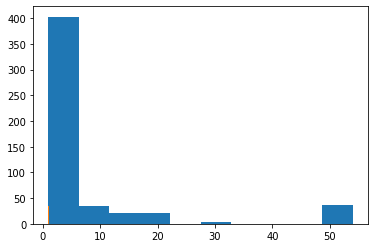

In [17]:
# CSM
csmTests= trial("csm")
csmSortTests = getSortTests(csmTests[0],csmTests[1])
csm = getTestValues(csmSortTests[0],csmSortTests[1])

In [18]:
#EUC
eucTests= trial("euc")
eucSortTests = getSortTests(eucTests[0],eucTests[1])
euc = getTestValues(eucSortTests[0],eucSortTests[1])

13.026175737380981EUC TIME
malware took 13.026176 seconds
0.8995950222015381EUC TIME


In [19]:
#BRAY CURTIS
brayTests= trial("bray")
braySortTests = getSortTests(brayTests[0],brayTests[1])
bray = getTestValues(braySortTests[0],braySortTests[1])

17.733590841293335Bray TIME
malware took 17.733591 seconds
1.188821792602539Bray TIME


In [20]:
#SQUARE EUCLIDEAN
sqeucTests = trial("sqeuc")
sqeucSortTests = getSortTests(sqeucTests[0],sqeucTests[1])
sqeuc = getTestValues(sqeucSortTests[0],sqeucSortTests[1])

12.17644715309143SQEUC TIME
malware took 12.176447 seconds
0.8467369079589844SQEUC TIME


In [21]:
#DISTANCE CORRELATION
corTests = trial("cor")
corSortTests = getSortTests(corTests[0],corTests[1])
cor = getTestValues(corSortTests[0],corSortTests[1])

52.98834180831909COR TIME
malware took 52.988342 seconds
3.456758499145508COR TIME


In [22]:
#PRODUCT Values
prodTests = trial("prod")
prodSortTests = getSortTests(prodTests[0],prodTests[1])
prod = getTestValues(prodSortTests[0],prodSortTests[1])

30.8764865398407PROD TIME
malware took 30.877481 seconds
2.088416814804077PROD TIME


In [23]:
#MINKOWSKI COSINE PRODUCT
minkTests = trial("mink")
minkSortTests = getSortTests(minkTests[0],minkTests[1])
mink = getTestValues(minkSortTests[0],minkSortTests[1])

52.93248987197876Mink TIME
malware took 52.932490 seconds
3.5634732246398926Mink TIME


In [24]:
print("TOTAL TIME TAKEN : "+str(time.time()-total_time))

TOTAL TIME TAKEN : 293.64098954200745


In [25]:
steps = 20
detect = detectSteps(csm[1],csm[0],steps, metric= "Csm")
detectEuc = detectSteps(euc[1],euc[0], steps, metric="Euc")
detectBray = detectSteps( bray[1],bray[0], steps, metric="Bray")
detectSq = detectSteps(sqeuc[1],sqeuc[0], steps, metric="Sqeuc")
detectCor = detectSteps(cor[1], cor[0], steps, metric="Dist Cor")
detectProd = detectSteps(prod[1], prod[0], steps, metric="Prod")
detectMink = detectSteps(mink[1], mink[0], steps, metric="Mink")

<Figure size 432x288 with 0 Axes>

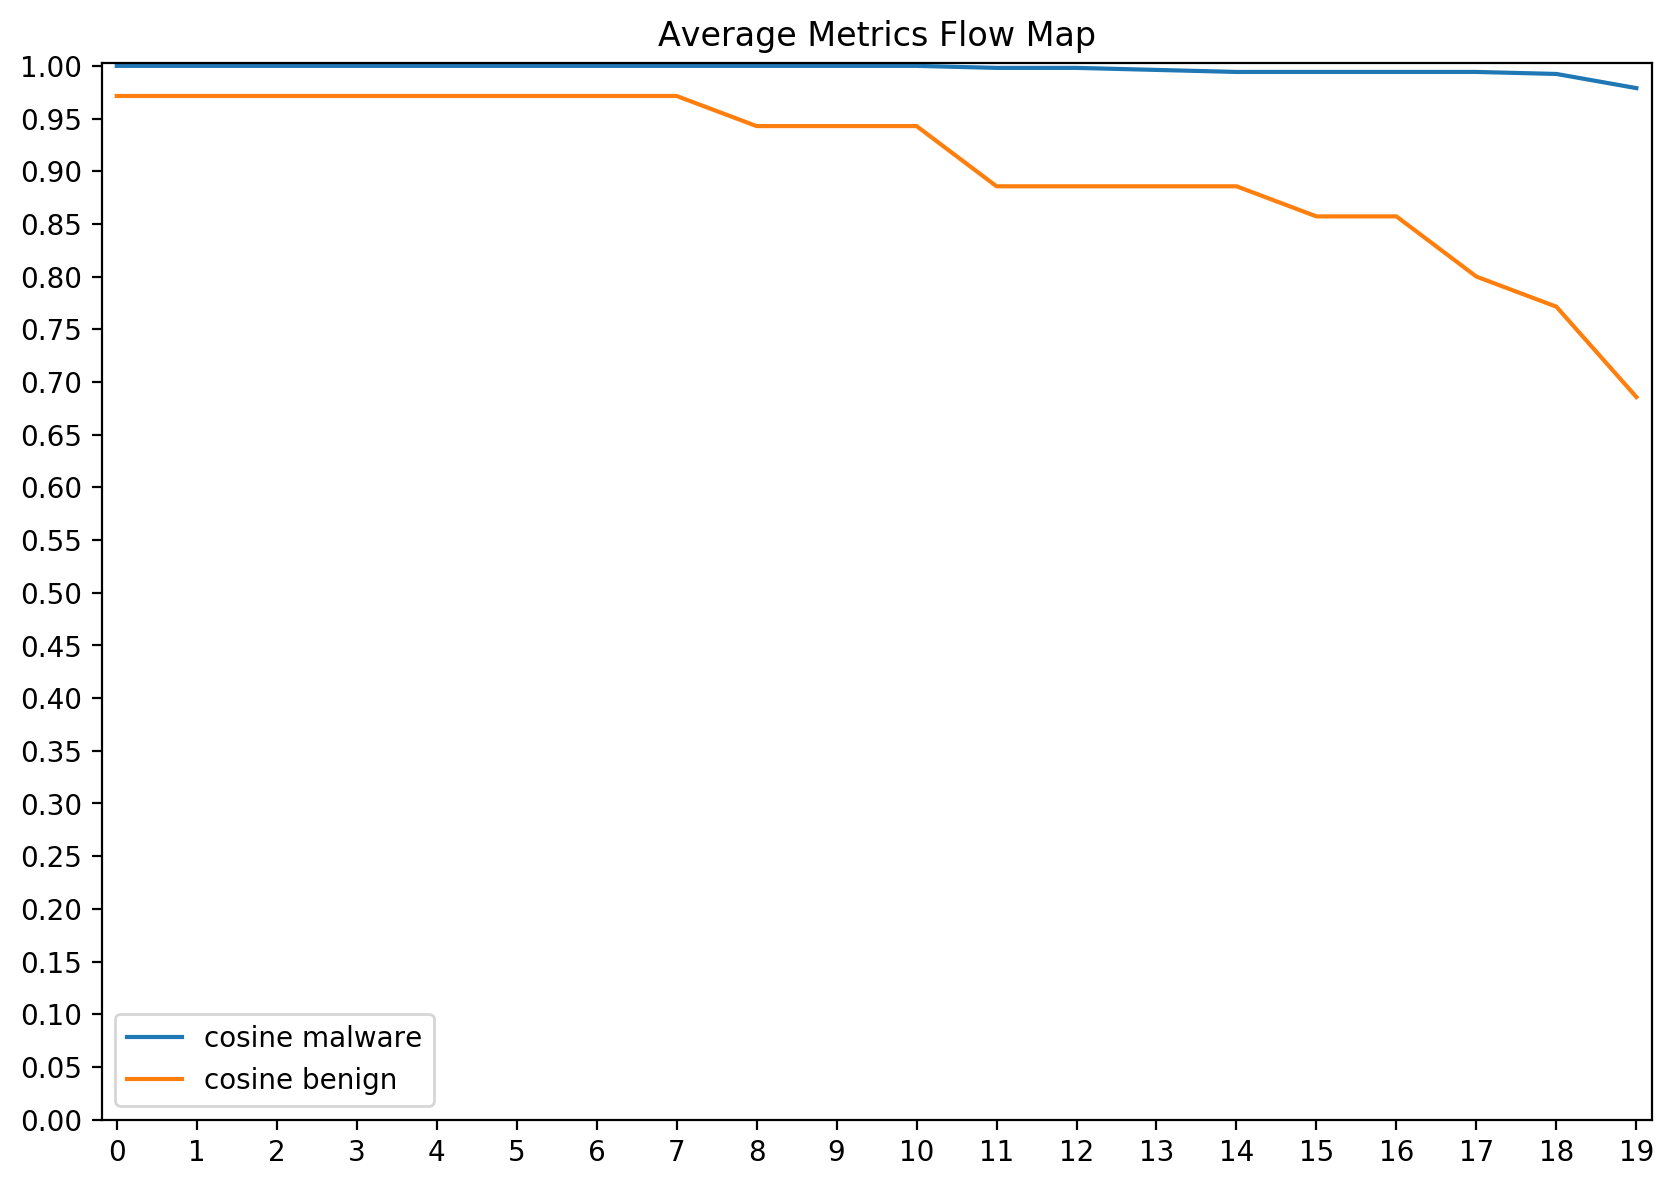

In [28]:
mal_det = np.array([detect[i][0] for i in range(len(detect))])
ben_det = np.array([detect[i][1] for i in range(len(detect))])
mal_euc = np.array([detectEuc[i][0] for i in range(len(detectEuc))])
ben_euc = np.array([detectEuc[i][1] for i in range(len(detectEuc))])
mal_bray = np.array([detectBray[i][0] for i in range(len(detectBray))])
ben_bray = np.array([detectBray[i][1] for i in range(len(detectBray))])
mal_sq = np.array([detectSq[i][0] for i in range(len(detectSq))])
ben_sq = np.array([detectSq[i][1] for i in range(len(detectSq))])
mal_cor = np.array([detectCor[i][0] for i in range(len(detectCor))])
ben_cor = np.array([detectCor[i][1] for i in range(len(detectCor))])
mal_prod = np.array([detectProd[i][0] for i in range(len(detectProd))])
ben_prod = np.array([detectProd[i][1] for i in range(len(detectProd))])
mal_mink = np.array([detectMink[i][0] for i in range(len(detectMink))])
ben_mink = np.array([detectMink[i][1] for i in range(len(detectMink))])

avg_det = np.mean(mal_det,axis=0)
avg_det_b = np.mean(ben_det,axis=0)
avg_euc = np.mean(mal_euc, axis =0)
avg_euc_b = np.mean(ben_euc,axis = 0)
avg_bray = np.mean(mal_bray, axis =0)
avg_bray_b = np.mean(ben_bray,axis = 0)
avg_sq = np.mean(mal_sq, axis =0)
avg_sqeuc_b = np.mean(ben_sq,axis = 0)
avg_cor = np.mean(mal_cor, axis =0)
avg_cor_b = np.mean(ben_cor,axis = 0)
avg_prod = np.mean(mal_prod, axis =0)
avg_prod_b = np.mean(ben_prod,axis = 0)
avg_mink = np.mean(mal_mink, axis =0)
avg_mink_b = np.mean(ben_mink,axis = 0)
# print(avg_det)
# print(avg_mink_b)
# print("avg_mink ///// avg_mink_b ///// avg_cos ///// avg_cos_b" )
# for i in range(len(avg_mink)):
#     print(str(i)+". "+ str(avg_mink[i])+" // "+str(avg_mink_b[i])+" $$ "+str(avg_det[i])+" // "+str(avg_det_b[i]))

figure(num=None, figsize=(10,7), dpi=200, facecolor='w', edgecolor='k')
plt.margins(0.01)
plt.title("Average Metrics Flow Map")
plt.plot(avg_det)
plt.plot(avg_det_b)
plt.xticks(np.arange(0,len(avg_det),1))
plt.yticks(np.arange(0,1.01,0.05))
plt.legend(["cosine malware", "cosine benign","euclidean malware", "euclidean benign", "BC malware", 
            "BC benign","Sqeuc malware", "Sqeuc benign","Correlation malware", "Correlation benign", "Product malware", "Product benign"])
plt.savefig("averages of all metrics GRG.png")

In [27]:
simAverages(csmSortTests[0],csmSortTests[1],"Csm")
print("===========================================")
print()
simAverages(eucSortTests[0],eucSortTests[1],"Euc")
print("===========================================")
print()
simAverages(braySortTests[0],braySortTests[1],"Bray")
print("===========================================")
print()
simAverages(sqeucSortTests[0],sqeucSortTests[1],"Sq")
print("===========================================")
print()
simAverages(corSortTests[0], corSortTests[1],"Cor")

[0.7773512476007678, 0.8387715930902111, 0.8502879078694817]
---------------
Csm
---------------
0.7773512476007678
0.8387715930902111
0.8502879078694817

[0.6660268714011516, 0.8023032629558541, 0.8138195777351248]
---------------
Euc
---------------
0.6660268714011516
0.8023032629558541
0.8138195777351248

[0.6717850287907869, 0.8138195777351248, 0.8310940499040307]
---------------
Bray
---------------
0.6717850287907869
0.8138195777351248
0.8310940499040307

[0.6660268714011516, 0.8023032629558541, 0.8138195777351248]
---------------
Sq
---------------
0.6660268714011516
0.8023032629558541
0.8138195777351248

[0.6621880998080614, 0.800383877159309, 0.8138195777351248]
---------------
Cor
---------------
0.6621880998080614
0.800383877159309
0.8138195777351248
